In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3 as sql
import os

sns.set()
con = sql.connect("./data.db")

con.execute(('CREATE TABLE IF NOT EXISTS "per" ('
             '"ln" INTEGER,'
             '"epoch" INTEGER,'
             '"val_loss" REAL,'
             '"val_categorical_accuracy" REAL,'
             '"loss" REAL,'
             '"categorical_accuracy" REAL,'
             '"use_batch_norm" TEXT,'
             '"optimizer" TEXT,'
             '"activation" TEXT,'
             '"layers" TEXT,'
             '"train_size" INTEGER,'
             '"reduction_method" TEXT,'
             '"number_of_feature" INTEGER'
             ');'))
# con.execute('CREATE INDEX "RM" on "per" ("reduction_method");')
# con.execute('CREATE INDEX "NF" on "per" ("number_of_feature");')
con.enable_load_extension(True)
con.load_extension("./extension-functions")

if not os.path.exists("graphs"):
    os.makedirs("graphs")

OperationalError: 找不到指定的模块。


In [2]:
def generate_sql_z_query(z_name: str, filters: dict):
    where_close = ""
    first_key = True
    for k, lf in filters.items():
        if first_key:
            first_key = False
        else:
            where_close += "AND "
        where_close += "("
        first = True
        for v in lf:
            if not first:
                where_close += " OR "
            else:
                first = False
            where_close += str(k)+"='"+str(v)+"'"
        where_close += ") "
    query = "SELECT DISTINCT "+z_name+" FROM per"
    if where_close != "":
        query += " WHERE " + where_close
    return query


def generate_sql_xy_query(x_name: str, y_name: str, z_name: str, z_value, filters: dict, x_limit):
    where_close = z_name+" = '"+str(z_value)+"' "
    for k, lf in filters.items():
        where_close += "AND ("
        first = True
        for v in lf:
            if not first:
                where_close += " OR "
            else:
                first = False
            where_close += str(k)+"='"+str(v)+"'"
        where_close += ") "
    if x_limit > 0:
        where_close += "AND " + x_name + " < " + str(x_limit) + " "
    query = ("SELECT " + x_name + ","
             "min(" + y_name + ") as min,"
             "max(" + y_name + ") as max,"
             "median(" + y_name + ") as median,"
             "avg(" + y_name + ") as mean "
             "FROM per ")
    if where_close != "":
        query += "WHERE " + where_close
    query += "GROUP BY " + x_name
    return query


def consolidate_data_from_db(con, x_name: str, y_name: str, z_name: str, filters: dict, x_limit=-1):
    z_value_df = pd.read_sql_query(generate_sql_z_query(z_name, filters), con)
    cd = dict()
    for i in z_value_df.get(z_name):
        query = generate_sql_xy_query(x_name, y_name, z_name, i, filters, x_limit)
        print("Selecting data for", z_name, "=", i)
        # print(query)
        cd[i] = pd.read_sql_query(query, con)
    return cd


def generate_plot(con, x_arg_name, y_arg_name, z_arg_name, filters, save_to_file=True, x_limit=-1, x_name=None, y_name=None):
    if x_name is None:
        x_name = x_arg_name
    if y_name is None:
        y_name = y_arg_name
        
    cd = consolidate_data_from_db(con, x_arg_name, y_arg_name, z_arg_name, filters, x_limit)

    plt.figure()
    plt.axes()
    for a, d in cd.items():
        plt.plot(d.get(x_arg_name), d.get('median'), 
                 label=z_arg_name.replace('_', ' ') + ' = ' + str(a).replace('_', ' '))
        # plt.fill_between(d.get(x_arg_name), d.get('mean') - d.get('std'), d.get('mean') + d.get('std'), alpha=0.3)
        plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
    if y_arg_name == "val_categorical_accuracy":
        plt.ylabel("Validation accuracy")
    else:
        plt.ylabel(y_name.replace('_',' '))
    plt.xlabel(x_name.replace('_',' '))
    plt.legend()
    # plt.title("Evolution of acuracy acording to the number of training examples")
    if save_to_file:
        algo_name = "all_"
        if "reduction_method" in filters.keys():
            algo_name = '_'.join(map(str, filters["reduction_method"])) + '_'
        layers = ""
        if "layers" in filters.keys():
            layers = '_' + '_'.join(map(lambda x: x.replace('(','').replace(')','').replace(',',''), filters["layers"]))
        plt.savefig("graphs/"+algo_name+x_name+"_"+y_name+"_"+z_arg_name+layers+".png")
    plt.show()

# General Plots

Selecting data for reduction_method = ICA
Selecting data for reduction_method = LDA
Selecting data for reduction_method = PCA
Selecting data for reduction_method = random


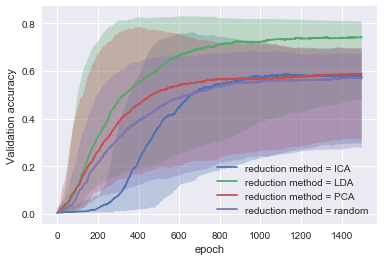

In [3]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='reduction_method',
              filters={},
              x_limit=1500)

Selecting data for reduction_method = ICA
Selecting data for reduction_method = LDA
Selecting data for reduction_method = PCA
Selecting data for reduction_method = random


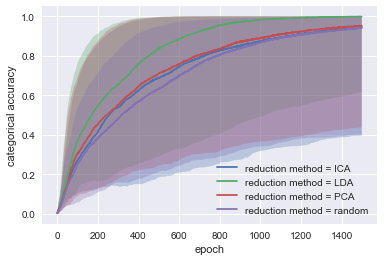

In [4]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='categorical_accuracy',
              z_arg_name='reduction_method',
              filters={},
              x_limit=1500)

Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 10
Selecting data for number_of_feature = 15
Selecting data for number_of_feature = 20
Selecting data for number_of_feature = 25
Selecting data for number_of_feature = 30
Selecting data for number_of_feature = 35
Selecting data for number_of_feature = 40


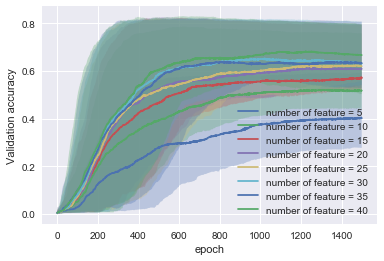

In [5]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='number_of_feature',
              filters={},
              x_limit=1500)

# LDA

Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 10
Selecting data for number_of_feature = 15
Selecting data for number_of_feature = 20
Selecting data for number_of_feature = 25
Selecting data for number_of_feature = 30
Selecting data for number_of_feature = 35
Selecting data for number_of_feature = 40


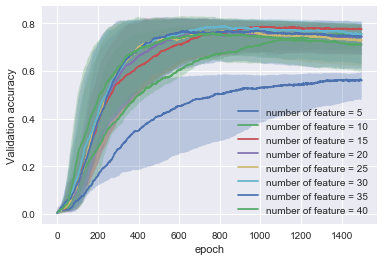

In [6]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='number_of_feature',
              filters={'reduction_method': ['LDA']},
              x_limit=1500)

Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 10
Selecting data for number_of_feature = 15
Selecting data for number_of_feature = 20
Selecting data for number_of_feature = 25
Selecting data for number_of_feature = 30
Selecting data for number_of_feature = 35
Selecting data for number_of_feature = 40


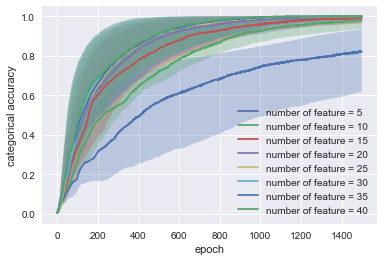

In [7]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='categorical_accuracy',
              z_arg_name='number_of_feature',
              filters={'reduction_method': ['LDA']},
              x_limit=1500)

Selecting data for layers = (35,)
Selecting data for layers = (25,)


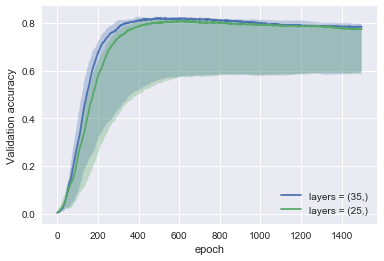

In [8]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='layers',
              filters={'reduction_method': ['LDA'], 'layers': ["(35,)", "(25,)"]},
              x_limit=1500)

Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 10
Selecting data for number_of_feature = 15
Selecting data for number_of_feature = 20
Selecting data for number_of_feature = 25
Selecting data for number_of_feature = 30
Selecting data for number_of_feature = 35
Selecting data for number_of_feature = 40


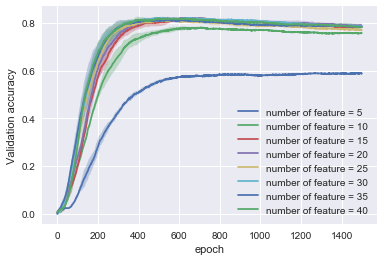

In [9]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='number_of_feature',
              filters={'reduction_method': ['LDA'], 'layers': ["(35,)", "(25,)"]},
              x_limit=1500)

Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 10
Selecting data for number_of_feature = 15
Selecting data for number_of_feature = 20
Selecting data for number_of_feature = 25
Selecting data for number_of_feature = 30
Selecting data for number_of_feature = 35
Selecting data for number_of_feature = 40


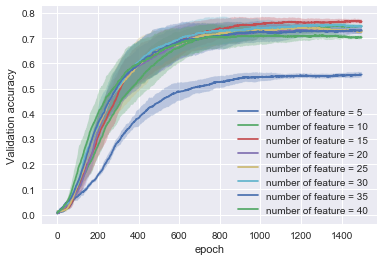

In [10]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='number_of_feature',
              filters={'reduction_method': ['LDA'], 'layers': ["(10,)", "(15,)"]},
              x_limit=1500)

# PCA

Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 10
Selecting data for number_of_feature = 15
Selecting data for number_of_feature = 20
Selecting data for number_of_feature = 25
Selecting data for number_of_feature = 30
Selecting data for number_of_feature = 35
Selecting data for number_of_feature = 40


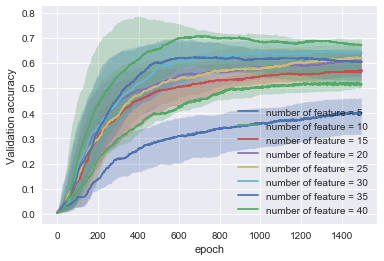

In [11]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='number_of_feature',
              filters={'reduction_method': ['PCA']},
              x_limit=1500)

Selecting data for layers = ()
Selecting data for layers = (35,)
Selecting data for layers = (25,)
Selecting data for layers = (15,)
Selecting data for layers = (10,)
Selecting data for layers = (30, 10)
Selecting data for layers = (20, 10)


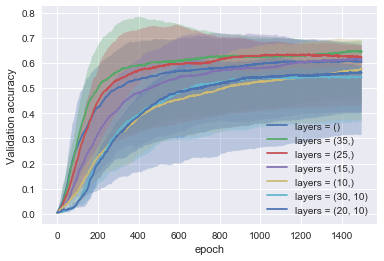

In [12]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='layers',
              filters={'reduction_method': ['PCA']},
              x_limit=1500)

Selecting data for layers = (35,)
Selecting data for layers = (25,)


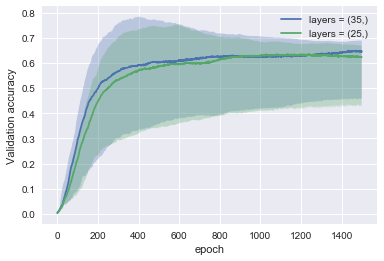

In [13]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='layers',
              filters={'reduction_method': ['PCA'], 'layers': ["(35,)", "(25,)"]},
              x_limit=1500)

Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 10
Selecting data for number_of_feature = 15
Selecting data for number_of_feature = 20
Selecting data for number_of_feature = 25
Selecting data for number_of_feature = 30
Selecting data for number_of_feature = 35
Selecting data for number_of_feature = 40


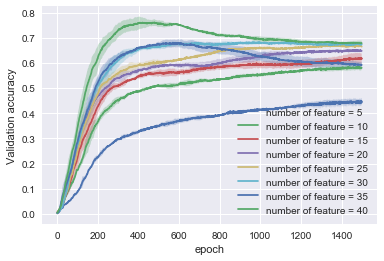

In [14]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='number_of_feature',
              filters={'reduction_method': ['PCA'], 'layers': ["(35,)", "(25,)"]},
              x_limit=1500)

Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 10
Selecting data for number_of_feature = 15
Selecting data for number_of_feature = 20
Selecting data for number_of_feature = 25
Selecting data for number_of_feature = 30
Selecting data for number_of_feature = 35
Selecting data for number_of_feature = 40


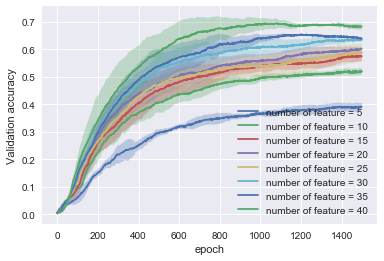

In [15]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='number_of_feature',
              filters={'reduction_method': ['PCA'], 'layers': ["(10,)", "(15,)"]},
              x_limit=1500)

# ICA

Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 10
Selecting data for number_of_feature = 15
Selecting data for number_of_feature = 20
Selecting data for number_of_feature = 25
Selecting data for number_of_feature = 30
Selecting data for number_of_feature = 35
Selecting data for number_of_feature = 40


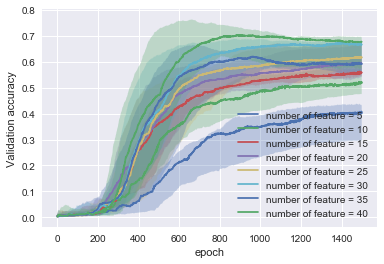

In [16]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='number_of_feature',
              filters={'reduction_method': ['ICA']},
              x_limit=1500)

Selecting data for layers = ()
Selecting data for layers = (35,)
Selecting data for layers = (25,)
Selecting data for layers = (15,)
Selecting data for layers = (10,)
Selecting data for layers = (30, 10)
Selecting data for layers = (20, 10)


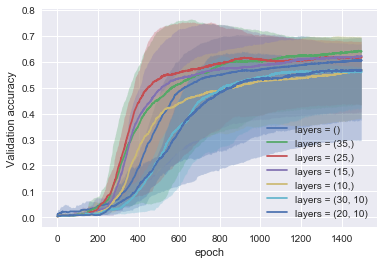

In [17]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='layers',
              filters={'reduction_method': ['ICA']},
              x_limit=1500)

Selecting data for layers = (35,)
Selecting data for layers = (25,)


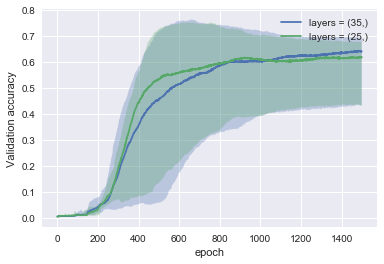

In [18]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='layers',
              filters={'reduction_method': ['ICA'], 'layers': ["(35,)", "(25,)"]},
              x_limit=1500)

Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 10
Selecting data for number_of_feature = 15
Selecting data for number_of_feature = 20
Selecting data for number_of_feature = 25
Selecting data for number_of_feature = 30
Selecting data for number_of_feature = 35
Selecting data for number_of_feature = 40


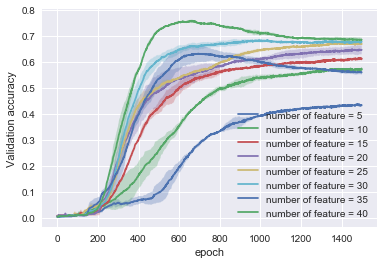

In [19]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='number_of_feature',
              filters={'reduction_method': ['ICA'], 'layers': ["(35,)", "(25,)"]},
              x_limit=1500)

Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 10
Selecting data for number_of_feature = 15
Selecting data for number_of_feature = 20
Selecting data for number_of_feature = 25
Selecting data for number_of_feature = 30
Selecting data for number_of_feature = 35
Selecting data for number_of_feature = 40


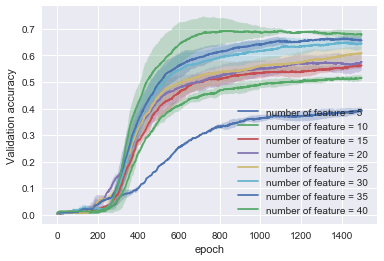

In [20]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='number_of_feature',
              filters={'reduction_method': ['ICA'], 'layers': ["(10,)", "(15,)"]},
              x_limit=1500)

# Random

Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 10
Selecting data for number_of_feature = 15
Selecting data for number_of_feature = 20
Selecting data for number_of_feature = 25
Selecting data for number_of_feature = 30
Selecting data for number_of_feature = 35
Selecting data for number_of_feature = 40


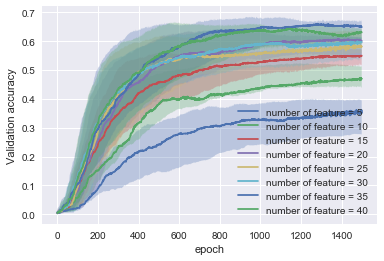

In [21]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='number_of_feature',
              filters={'reduction_method': ['random']},
              x_limit=1500)

Selecting data for layers = (35,)
Selecting data for layers = (25,)


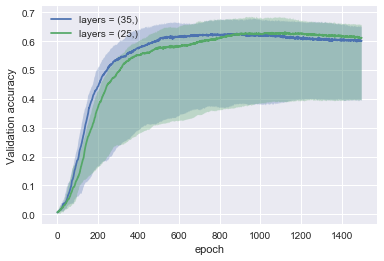

In [22]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='layers',
              filters={'reduction_method': ['random'], 'layers': ["(35,)", "(25,)"]},
              x_limit=1500)

Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 10
Selecting data for number_of_feature = 15
Selecting data for number_of_feature = 20
Selecting data for number_of_feature = 25
Selecting data for number_of_feature = 30
Selecting data for number_of_feature = 35
Selecting data for number_of_feature = 40


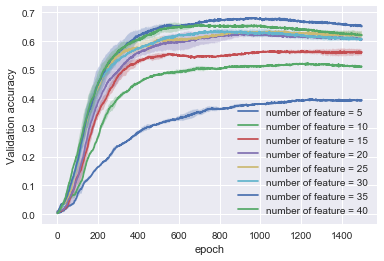

In [23]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='number_of_feature',
              filters={'reduction_method': ['random'], 'layers': ["(35,)", "(25,)"]},
              x_limit=1500)

Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 10
Selecting data for number_of_feature = 15
Selecting data for number_of_feature = 20
Selecting data for number_of_feature = 25
Selecting data for number_of_feature = 30
Selecting data for number_of_feature = 35
Selecting data for number_of_feature = 40


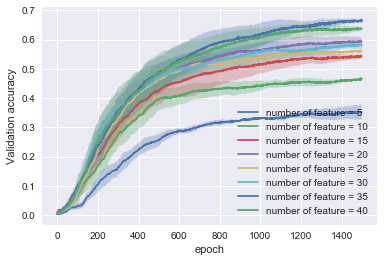

In [24]:
generate_plot(con=con,
              x_arg_name='epoch',
              y_arg_name='val_categorical_accuracy',
              z_arg_name='number_of_feature',
              filters={'reduction_method': ['random'], 'layers': ["(10,)", "(15,)"]},
              x_limit=1500)